In [2]:
import os
import cv2
import matplotlib.pyplot as plt

image_dir = r"C:/Users/Raneem/Desktop/car/train/images"
label_dir = r"C:/Users/Raneem/Desktop/car/train/annotations"



In [3]:
# convert json format to  yolo format.

import json
import os

json_path = r"C:/Users/Raneem/Desktop/car/train/annotations/bdd100k_labels_images_train.json"

image_dir = r"C:/Users/Raneem/Desktop/car/train/images"
label_dir = r"C:/Users/Raneem/Desktop/car/train/labels"


os.makedirs(label_dir, exist_ok=True)


classes = ["person", "car", "bus", "truck", "rider", "bike", "motor", "train", "traffic light", "traffic sign"]

with open(json_path, "r") as f:
    data = json.load(f)

for item in data:
    img_name = item["name"]
    labels_txt = []

    
    img_w, img_h = 1280, 720

    for label in item["labels"]:
        if "category" not in label:
            continue
        category = label["category"]

        if category not in classes:
            continue

        cls_id = classes.index(category)

        
        if "box2d" not in label:
            continue

        box = label["box2d"]
        x1, y1, x2, y2 = box["x1"], box["y1"], box["x2"], box["y2"]

        
        x_center = ((x1 + x2) / 2) / img_w
        y_center = ((y1 + y2) / 2) / img_h
        width = (x2 - x1) / img_w
        height = (y2 - y1) / img_h

        labels_txt.append(f"{cls_id} {x_center} {y_center} {width} {height}")

    
    if labels_txt:
        txt_path = os.path.join(label_dir, img_name.replace(".jpg", ".txt"))
        with open(txt_path, "w") as f:
            f.write("\n".join(labels_txt))


In [ ]:
import os
import shutil


images_folder = r"C:\Users\Raneem\Desktop\car\train\images"
labels_folder = r"C:\Users\Raneem\Desktop\car\train\labels"


backup_folder = r"C:\Users\Raneem\Desktop\car\train\images_without_labels"
os.makedirs(backup_folder, exist_ok=True)


images = set(f.replace(".jpg","") for f in os.listdir(images_folder) if f.endswith(".jpg"))
labels = set(f.replace(".txt","") for f in os.listdir(labels_folder) if f.endswith(".txt"))


images_without_labels = images - labels
print(f"Found {len(images_without_labels)} images without labels.")


for img_name in images_without_labels:
    img_path = os.path.join(images_folder, img_name + ".jpg")
    dest_path = os.path.join(backup_folder, img_name + ".jpg")
    if os.path.exists(img_path):
        shutil.move(img_path, dest_path)

print(f"Moved {len(images_without_labels)} images without labels to backup folder:\n{backup_folder}")


Found 137 images without labels.
Moved 137 images without labels to backup folder:
C:\Users\Raneem\Desktop\car\train\images_without_labels


In [4]:
import os
import random
import cv2
import albumentations as A
import json

src_images = r"C:\Users\Raneem\Desktop\car\train\images"
src_labels = r"C:\Users\Raneem\Desktop\car\train\labels"

dst_images = r"C:\Users\Raneem\Desktop\car\train\images_final"
dst_labels = r"C:\Users\Raneem\Desktop\car\train\labels_final"

os.makedirs(dst_images, exist_ok=True)
os.makedirs(dst_labels, exist_ok=True)

augmentations = {
    "RandomBrightnessContrast": A.RandomBrightnessContrast(p=1),
    "HorizontalFlip": A.HorizontalFlip(p=1),
    "RandomCrop": A.RandomCrop(width=400, height=400, p=1),
    "Rotate": A.Rotate(limit=30, p=1),
    "GaussianBlur": A.GaussianBlur(blur_limit=(3, 7), p=1),
    "RandomGamma": A.RandomGamma(p=1),
    "CLAHE": A.CLAHE(p=1),
    "RandomShadow": A.RandomShadow(p=1),
    "RGBShift": A.RGBShift(r_shift_limit=20, g_shift_limit=20, b_shift_limit=20, p=1)
}

def get_transform(chosen):
    return A.Compose(
        [aug for _, aug in chosen],
        bbox_params=A.BboxParams(
            format="yolo",
            label_fields=["class_labels"]
        )
    )

all_images = [f for f in os.listdir(src_images) if f.endswith(".jpg")]


num_to_augment = int(len(all_images) * 0.3)
augment_images = set(random.sample(all_images, num_to_augment))

aug_info = {}

for file_name in all_images:
    src_img_path = os.path.join(src_images, file_name)
    src_lbl_path = os.path.join(src_labels, file_name.replace(".jpg", ".txt"))

    dst_img_path = os.path.join(dst_images, file_name)
    dst_lbl_path = os.path.join(dst_labels, file_name.replace(".jpg", ".txt"))

    img = cv2.imread(src_img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    bboxes, class_labels = [], []
    if os.path.exists(src_lbl_path):
        with open(src_lbl_path, "r") as f:
            for line in f.readlines():
                parts = line.strip().split()
                cls = int(parts[0])
                x, y, bw, bh = map(float, parts[1:])
                bboxes.append([x, y, bw, bh])
                class_labels.append(cls)

    if file_name in augment_images and len(bboxes) > 0:
        
        num_aug = random.choice([1, 2, 3])
        chosen = random.sample(list(augmentations.items()), num_aug)
        transform = get_transform(chosen)

        transformed = transform(image=img, bboxes=bboxes, class_labels=class_labels)
        img = transformed["image"]
        bboxes = transformed["bboxes"]
        class_labels = transformed["class_labels"]

        aug_info[file_name] = [name for name, _ in chosen]
    else:
        aug_info[file_name] = ["No Augmentation"]

    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    cv2.imwrite(dst_img_path, img)

    with open(dst_lbl_path, "w") as f:
        for cls, (x, y, bw, bh) in zip(class_labels, bboxes):
            f.write(f"{cls} {x:.6f} {y:.6f} {bw:.6f} {bh:.6f}\n")


with open(os.path.join(dst_labels, "augmentation_info.json"), "w") as f:
    json.dump(aug_info, f, indent=4)

print(f"Created final dataset with {len(all_images)} images.")
print(f" All saved in:\n  Images: {dst_images}\n  Labels: {dst_labels}")
print(" Augmentation details saved in augmentation_info.json")


C:\Users\Raneem\AppData\Roaming\Python\Python312\site-packages\albumentations\core\composition.py:331: UserWarning: Got processor for bboxes, but no transform to process it.
  self._set_keys()


Created final dataset with 69863 images.
 All saved in:
  Images: C:\Users\Raneem\Desktop\car\train\images_final
  Labels: C:\Users\Raneem\Desktop\car\train\labels_final
 Augmentation details saved in augmentation_info.json


In [6]:
# Convert JSON format to YOLO format for validation set

import json
import os

json_path = r"C:/Users/Raneem/Desktop/car/val/annotations/bdd100k_labels_images_val.json"

image_dir = r"C:/Users/Raneem/Desktop/car/val/images"

label_dir = r"C:/Users/Raneem/Desktop/car/val/labels"

os.makedirs(label_dir, exist_ok=True)


classes = ["person", "car", "bus", "truck", "rider", "bike", "motor", "train", "traffic light", "traffic sign"]


with open(json_path, "r") as f:
    data = json.load(f)

for item in data:
    img_name = item["name"]
    labels_txt = []

    
    img_w, img_h = 1280, 720

    for label in item["labels"]:
        if "category" not in label:
            continue
        category = label["category"]

        if category not in classes:
            continue

        cls_id = classes.index(category)

        if "box2d" not in label:
            continue

        box = label["box2d"]
        x1, y1, x2, y2 = box["x1"], box["y1"], box["x2"], box["y2"]

        
        x_center = ((x1 + x2) / 2) / img_w
        y_center = ((y1 + y2) / 2) / img_h
        width = (x2 - x1) / img_w
        height = (y2 - y1) / img_h

        labels_txt.append(f"{cls_id} {x_center} {y_center} {width} {height}")

    
    if labels_txt:
        txt_path = os.path.join(label_dir, img_name.replace(".jpg", ".txt"))
        with open(txt_path, "w") as f:
            f.write("\n".join(labels_txt))


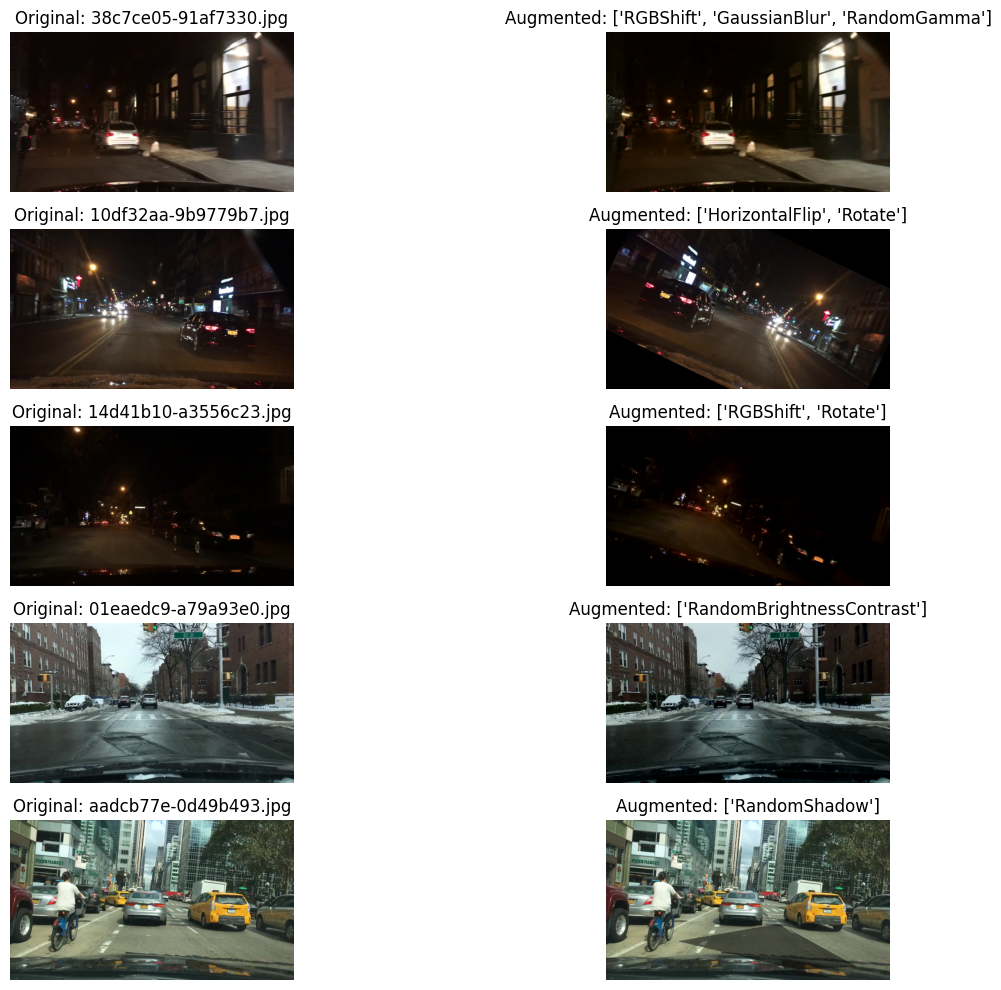

In [ ]:
import os
import random
import json
import cv2
import matplotlib.pyplot as plt

#paths
src_images = r"C:\Users\Raneem\Desktop\car\train\images"
dst_images = r"C:\Users\Raneem\Desktop\car\train\images_final"
aug_info_path = r"C:\Users\Raneem\Desktop\car\train\labels_final\augmentation_info.json"

# read augmentation file
with open(aug_info_path, "r") as f:
    aug_info = json.load(f)

# select 5 random Augmented images
augmented_files = [f for f, augs in aug_info.items() if augs[0] != "No Augmentation"]
sample_files = random.sample(augmented_files, 5)

# show images
plt.figure(figsize=(15, 10))

for i, file_name in enumerate(sample_files, 1):
    #original
    src_img_path = os.path.join(src_images, file_name)
    src_img = cv2.imread(src_img_path)
    src_img = cv2.cvtColor(src_img, cv2.COLOR_BGR2RGB)

    #after editing
    dst_img_path = os.path.join(dst_images, file_name)
    dst_img = cv2.imread(dst_img_path)
    dst_img = cv2.cvtColor(dst_img, cv2.COLOR_BGR2RGB)

    #show the two images
    plt.subplot(5, 2, 2*i-1)
    plt.imshow(src_img)
    plt.axis("off")
    plt.title(f"Original: {file_name}")

    plt.subplot(5, 2, 2*i)
    plt.imshow(dst_img)
    plt.axis("off")
    plt.title(f"Augmented: {aug_info[file_name]}")

plt.tight_layout()
plt.show()


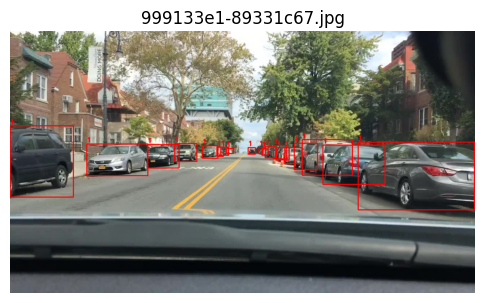

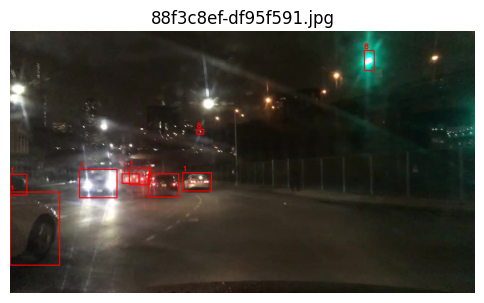

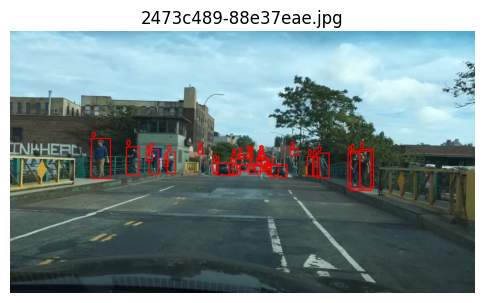

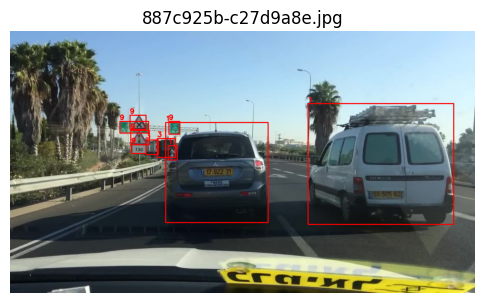

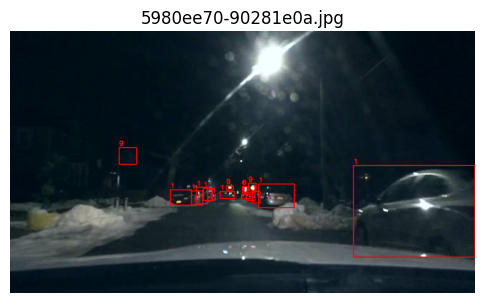

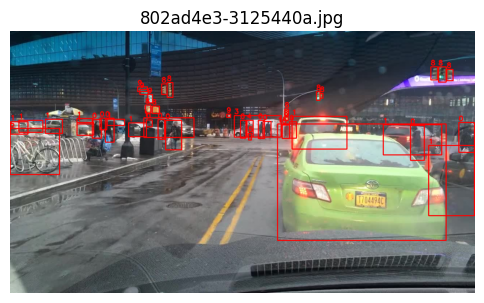

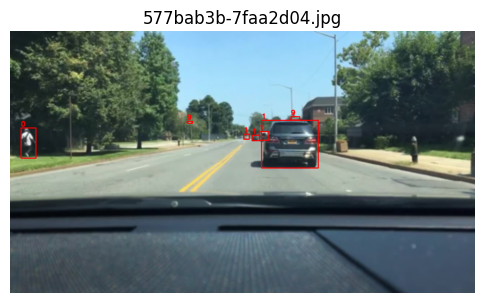

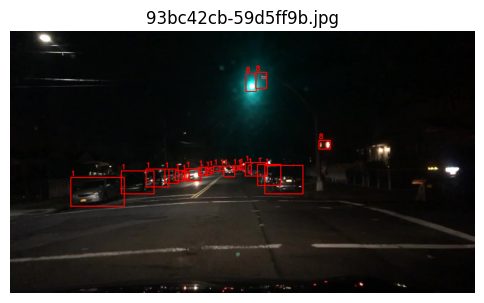

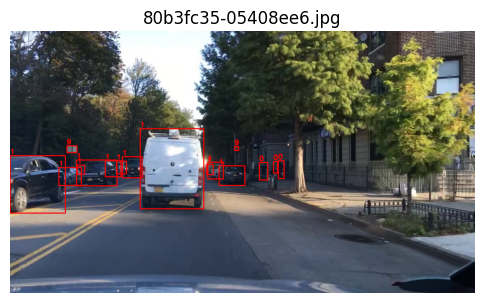

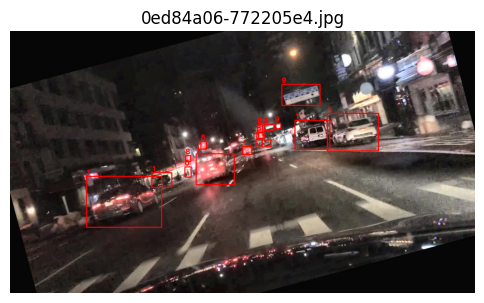

In [ ]:
import os
import cv2
import random
import matplotlib.pyplot as plt

# paths
images_path = r"C:\Users\Raneem\Desktop\car\train\images_final"
labels_path = r"C:\Users\Raneem\Desktop\car\train\labels_final"

#get all images
all_images = [f for f in os.listdir(images_path) if f.endswith(".jpg")]

#get 10 random images
sample_images = random.sample(all_images, 10)

for img_file in sample_images:
    img_path = os.path.join(images_path, img_file)
    label_path = os.path.join(labels_path, img_file.replace(".jpg", ".txt"))

    # read images
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    h, w, _ = img.shape

    # draw labels if there
    if os.path.exists(label_path):
        with open(label_path, "r") as f:
            for line in f.readlines():
                cls, x, y, bw, bh = map(float, line.strip().split())
                
                # YOLO format → pixel values
                x1 = int((x - bw / 2) * w)
                y1 = int((y - bh / 2) * h)
                x2 = int((x + bw / 2) * w)
                y2 = int((y + bh / 2) * h)
                
                # draw labels + classes
                cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 2)
                cv2.putText(img, str(int(cls)), (x1, y1 - 5),
                            cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)

    # show images
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis("off")
    plt.title(img_file)
    plt.show()
